In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import time

In [4]:
# Directories for training, validation, and testing
train_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/1.train"
val_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/2.val"
test_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/3.test"

# Image Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Augmentation & Preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define a simple DeepCaps-like model in PyTorch
class DeepCaps(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(DeepCaps, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(256 * (input_shape[1] // 8) * (input_shape[2] // 8), num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Build DeepCaps Model
model = DeepCaps(input_shape=(3, 224, 224), num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the Model
epochs = 10
train_acc_history, val_acc_history = [], []
start_time = time.time()

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = correct / total
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

training_time = time.time() - start_time

# Evaluate Model
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

class_labels = train_dataset.classes
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Epoch [1/10], Train Accuracy: 0.3354, Validation Accuracy: 0.4559
Epoch [2/10], Train Accuracy: 0.4467, Validation Accuracy: 0.4485
Epoch [3/10], Train Accuracy: 0.5376, Validation Accuracy: 0.5221
Epoch [4/10], Train Accuracy: 0.5815, Validation Accuracy: 0.5441
Epoch [5/10], Train Accuracy: 0.6223, Validation Accuracy: 0.5074
Epoch [6/10], Train Accuracy: 0.6505, Validation Accuracy: 0.5662
Epoch [7/10], Train Accuracy: 0.6755, Validation Accuracy: 0.5221
Epoch [8/10], Train Accuracy: 0.6881, Validation Accuracy: 0.5368
Epoch [9/10], Train Accuracy: 0.7022, Validation Accuracy: 0.5368
Epoch [10/10], Train Accuracy: 0.7288, Validation Accuracy: 0.5662
Classification Report:
                         precision    recall  f1-score   support

         1. No DR signs       0.45      0.75      0.56        28
2. Mild (or early) NPDR       0.89      1.00      0.94        24
       3. Moderate NPDR       0.17      0.08      0.11        12
         4. Severe NPDR       0.62      0.77      0.69 

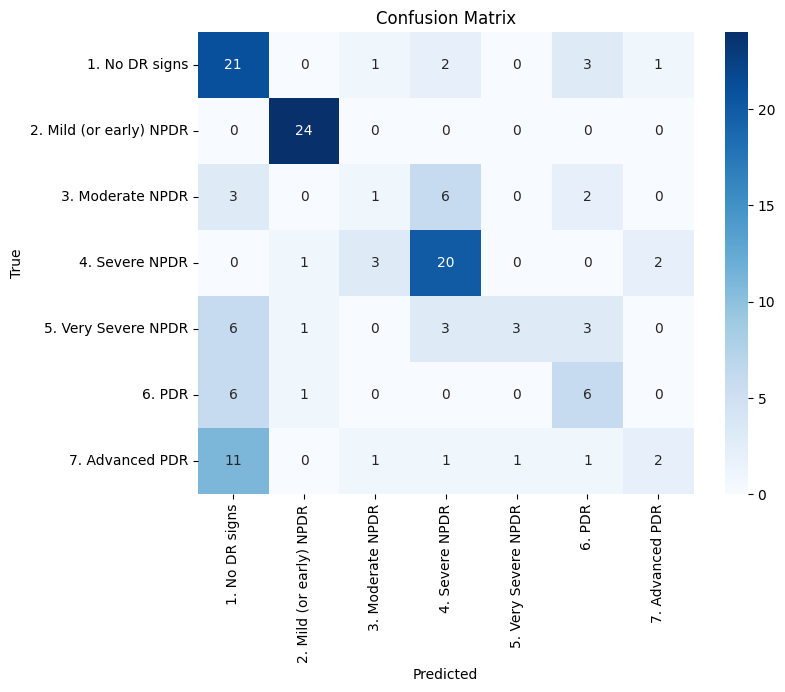

Training Time: 500.72 seconds
Accuracy: 0.5662
Precision: 0.5253
Recall (Sensitivity): 0.4813
F1-Score: 0.4589
Specificity: 0.8604


In [5]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute Metrics
TN = np.diag(cm).sum() - cm.sum(axis=0)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
accuracy = np.trace(cm) / np.sum(cm)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {np.mean(precision):.4f}")
print(f"Recall (Sensitivity): {np.mean(recall):.4f}")
print(f"F1-Score: {np.mean(f1_score):.4f}")
print(f"Specificity: {np.mean(specificity):.4f}")
